In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import torch.nn as nn

df = pd.read_pickle('final-locs.pkl')

In [2]:
sub = df[['full_sea', 'lat, long', 'timestamp']]
sub.set_index('timestamp')

df_new = {}
for i in sub['lat, long'].unique():
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = sub[sub['lat, long'] == i].iloc[:int(len(sub[sub['lat, long'] == i])*0.8)], sub[sub['lat, long'] == i].iloc[int(len(sub[sub['lat, long'] == i])*0.8):]

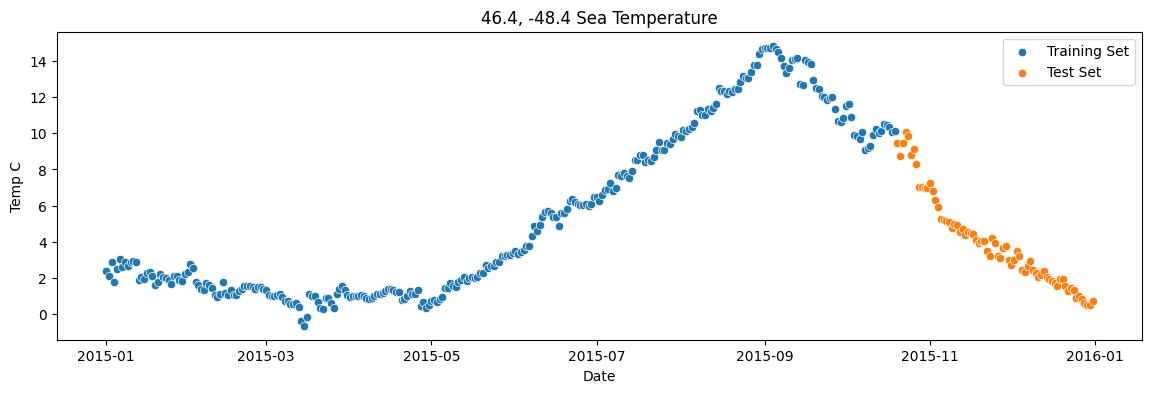

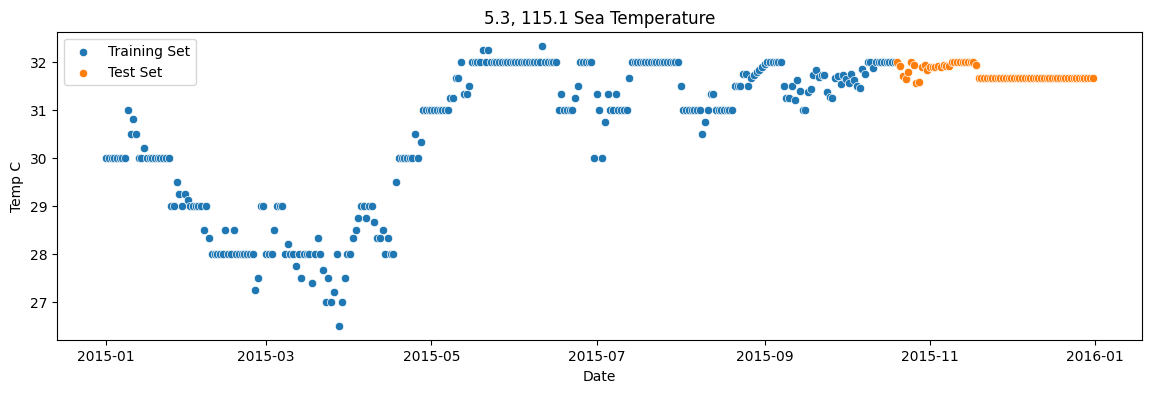

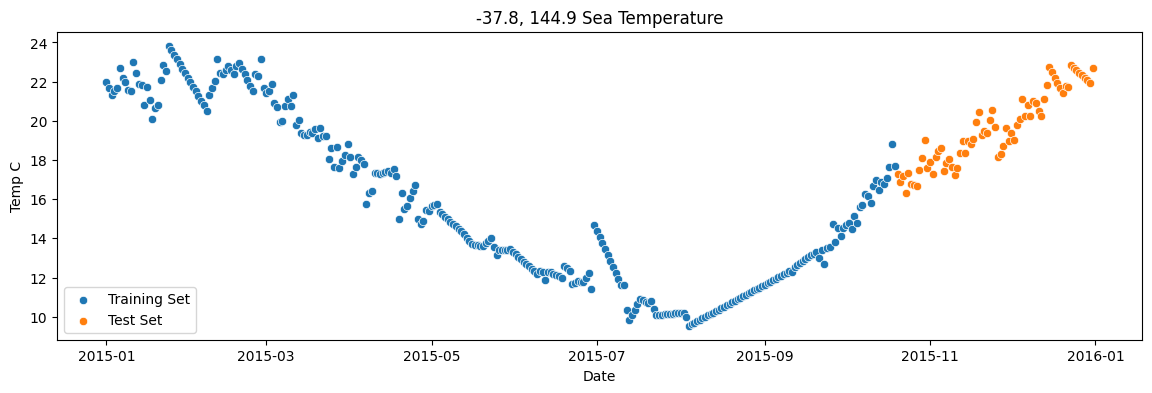

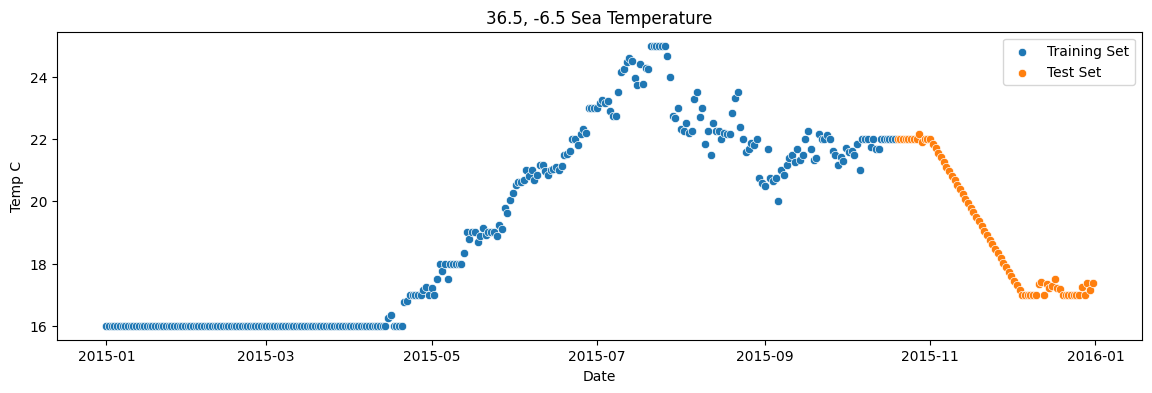

In [3]:
import seaborn as sns

for i in df['lat, long'].unique():
    plt.figure(figsize=(14,4))
    sns.scatterplot(y=df_new[i]["Train"]['full_sea'], x=df_new[i]['Train']['timestamp'])
    sns.scatterplot(y=df_new[i]["Test"]['full_sea'], x=df_new[i]['Test']['timestamp'])
    plt.ylabel("Temp C")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Sea Temperature")

In [4]:
from sklearn.preprocessing import MinMaxScaler

transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(df['lat, long'].unique()):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"]['full_sea'])
    a1 = np.array(df_new[i]["Test"]['full_sea'])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [5]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)

print("\n")   

for i in transform_test.keys():
    print(i, transform_test[i].shape)

46.4, -48.4 (292, 1)
5.3, 115.1 (292, 1)
-37.8, 144.9 (292, 1)
36.5, -6.5 (292, 1)


46.4, -48.4 (73, 1)
5.3, 115.1 (73, 1)
-37.8, 144.9 (73, 1)
36.5, -6.5 (73, 1)


In [6]:
def dataload(seq):
    trainset = {}
    testset = {}

    for j in df['lat, long'].unique():
        trainset[j] = {}
        X_train = []
        y_train = []
        
        for i in range(seq, 292):
            X_train.append(transform_train[j][i-seq:i,0])
            y_train.append(transform_train[j][i,0])
        
        X_train, y_train = np.array(X_train), np.array(y_train)
        trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
        trainset[j]["y"] = y_train
        
        testset[j] = {}
        X_test = []
        y_test = []    
        
        for i in range(seq, 73):
            X_test.append(transform_test[j][i-seq:i,0])
            y_test.append(transform_test[j][i,0])
        
        X_test, y_test = np.array(X_test), np.array(y_test)
        testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
        testset[j]["y"] = y_test

    return trainset, testset

In [7]:
trainset, testset = dataload(7)

In [8]:
arr_buff = []

for i in df['lat, long'].unique():
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=df['lat, long'].unique())

,X_train,y_train,X_test,y_test
"46.4, -48.4","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"5.3, 115.1","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"-37.8, 144.9","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"36.5, -6.5","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"


In [9]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 1  # Number of features in input data (e.g., time series)
hidden_size = 20  # Number of hidden units in the RNN
num_layers = 2  # Number of RNN layers
output_size = 1  # Number of features in output data (e.g., regression target)

# Instantiate the model
rnn = RNN(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(rnn)

RNN(
  (rnn): RNN(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


In [398]:
import torch.optim as optim
import torch.nn as nn

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 1  # Number of features in input data (e.g., time series)
hidden_size = 20  # Number of hidden units in the LSTM
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of features in output data (e.g., regression target)

# Instantiate the model
lstm = LSTM(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(lstm)

LSTM(
  (lstm): LSTM(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


# Train Methods

In [433]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def call(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'INFO: Early stopping counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [28]:
import wandb

sweep_configs = {
    "name": "BA 865 Project",
    "method": "grid",
    "metric": {"goal": "maximize", "name": "test_accuracy"},
    "parameters": {
        "learning_rate": {"values": [1e-1, 1e-2, 1e-3]},
        "momentum": {"values": [0.85, 0.9, 0.95]},
        "epochs": {"values": [100, 500, 1000]}},
    }

def main():
  model = RNN(input_size, hidden_size, num_layers, output_size)

    # 2.2 Compile the model
  def train_model(config=None):
    with wandb.init(config=config):
      config = wandb.config
      criterion_training = nn.MSELoss()
      criterion_testing = nn.MSELoss()
      optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=config.momentum)

    for i in df['lat, long'].unique():
      # Putting the y data in the correct format
      X_train = trainset[i]["X"]
      y_train = trainset[i]["y"]

      # Train the model
      for epoch in range(config.epochs):
        optimizer.zero_grad()
        model.train()
        pred = model(X_train)

        predictions_train_actual = torch.tensor(scaler.inverse_transform(pred.detach()))
        actual_train_error = criterion_training(predictions_train_actual, y_train.reshape(-1, 1))

        loss = criterion_training(pred, y_train)
        wandb.log({f"location_{i}_train_loss": loss, "location_{i}_train_accuracy": actual_train_error})
        # Update model here based on error
        loss.backward()
        optimizer.step()

      tests = []
      for i in df['lat, long'].unique():
        model.eval()
        X_test = testset[i]["X"]
        y_test = testset[i]["y"]
        
        # Evaluate the model on the test data
        with torch.no_grad():
          # Evaluate the model here.
          pred_test = model(X_test)
          loss_test = criterion_testing(pred_test, y_test)

          predictions_test_actual = torch.tensor(scaler.inverse_transform(pred_test.detach()))
          actual_test_error = criterion_testing(predictions_test_actual, y_test.reshape(-1, 1))
          
          wandb.log({f"location_{i}_test_loss": loss_test, "location_{i}_test_accuracy": actual_test_error})
          tests.append(actual_test_error)

        wandb.run.summary["multi-locational_test_accuracy"] = np.mean(tests)

# Step 3: Initialize sweep by passing in the config.
  sweep_id = wandb.sweep(sweep_configs, project = 'project test 2')
  wandb.agent(sweep_id, function=train_model)

# Step 4: Start sweep job.
main()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: u76chtv9
Sweep URL: https://wandb.ai/jbbjr/project%20test%202/sweeps/u76chtv9


wandb: Ctrl + C detected. Stopping sweep.


In [25]:
import wandb

sweep_config = {
    "method": "grid",
    "metric": {"goal": "maximize", "name": "test_accuracy"},
    "parameters": {
        "learning_rate": {"values": [1e-1, 1e-2, 1e-3]},
        "momentum": {"values": [0.85, 0.9, 0.95]},
        "epochs": {"values": [100, 500, 1000]}},
    }

def wandb_train(model_name, loss):
    wandb.login()
    
    if model_name == "RNN":
        global rnn
        instance = rnn
    elif model_name == "LSTM":
        global lstm
        instance = lstm
    
    loss = loss
    
    def train(config=None, loss=loss):
        with wandb.init(project='multi-location-sea-level-prediction', config=config):
            config = wandb.config
            criterion = loss
            optimizer = optim.Adam(instance.parameters(), lr=config.learning_rate, momentum=config.momentum)
            early_stopping = EarlyStopping(patience=config.patience, verbose=True)

            print('Training started...')
            for i in df['lat, long'].unique():
                X_train = trainset[i]["X"]
                y_train = trainset[i]["y"]

                for epoch in range(config.epochs):
                    instance.train()
                    optimizer.zero_grad()
                    output = instance(X_train)
                    loss = criterion(output, y_train.reshape(-1, 1))
                    loss.backward()
                    optimizer.step()
                    print(f'Location_{i}_loss_training: {loss.item()}')

                    wandb.log({f'Location_{i}_loss_training': loss.item(), 'epoch': epoch})

                
            tests = []
            for i in df['lat, long'].unique():
                X_test = testset[i]["X"]
                y_test = testset[i]["y"]

                instance.eval()
                with torch.no_grad():
                    output = instance(X_test)
                    val_loss = criterion(output, y_test.reshape(-1, 1))
                    wandb.log({f'Location_{i}_loss_validation': val_loss.item()})
                    tests.append(val_loss.item())
                    print(f'Location_{i}_loss_validation: {val_loss.item()}')
                    # early_stopping.call(val_loss)

                    # if early_stopping.early_stop:
                    #     print("INFO: Early stopping")
                    #     break

                    # wandb.log({"loss": loss.item(), "val_loss": val_loss.item()})
            wandb.run.summary['test_accuracy'] = sum(tests) / len(tests)

    sweep_id = wandb.sweep(sweep_config, project='multi-location-sea-level-prediction')
    wandb.agent(sweep_id, function=train)

In [11]:
def train(model, eval=str):
    preds = {}

    # Define the loss function
    if eval == "L1":
        criterion = nn.L1Loss()  # Mean Absolute Error (MAE) loss
    
    if eval == "MSE":
        criterion = nn.MSELoss()  # Mean Squared Error (MSE) loss

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trains = []
    for i in df['lat, long'].unique():
        # Convert numpy arrays to PyTorch tensors
        X_train = torch.tensor(trainset[i]["X"], dtype=torch.float32)
        y_train = torch.tensor(trainset[i]["y"], dtype=torch.float32)
        
        num_epochs = 500
        # Training loop
        for epoch in range(num_epochs):
            # Forward pass
            outputs = model(X_train)
            
            # Calculate loss
            loss = criterion(outputs, y_train.reshape(-1, 1))
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

        # Evaluation
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            outputs = model(X_train)
            
            # Reshape the target data to match the shape of the model's output
            y_train_reshaped = y_train.reshape(-1, 1)
            
            loss_train = criterion(outputs, y_train_reshaped)
            trains.append(loss_train.item())
            print(f'\nMAE Loss on Training Set for {i}: {loss_train.item():.4f}')
            preds[i] = scaler[i].inverse_transform(outputs.numpy())

            # Calculate training accuracy
            train_accuracy = torch.mean(torch.abs(outputs - y_train)).item()

        
    tests = []    
    for i, j in zip(df['lat, long'].unique(), trains):
        # Evaluate on test set
        X_test = torch.tensor(testset[i]["X"], dtype=torch.float32)
        y_test = torch.tensor(testset[i]["y"], dtype=torch.float32)
        
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            test_outputs = model(X_test)
            test_accuracy = torch.mean(torch.abs(test_outputs - y_test)).item()
            loss_test = criterion(test_outputs, y_test.reshape(-1, 1))
            preds[i] = scaler[i].inverse_transform(test_outputs.numpy())

        # Print progress
        print(f'\nEpoch [{epoch+1}/{num_epochs}], Training {eval}: {j:.4f}, Test {eval}: {loss_test:.4f}')
        tests.append(loss_test.item())
        # model.train()  # Set the model back to training mode
    
    return preds

In [12]:
def old_train(model, eval=str):
    preds = {}

    # Define the loss function
    if eval == "L1":
        criterion = nn.L1Loss()  # Mean Absolute Error (MAE) loss
    
    if eval == "MSE":
        criterion = nn.MSELoss()  # Mean Squared Error (MSE) loss

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for i in df['lat, long'].unique():
        # Convert numpy arrays to PyTorch tensors
        X_train = torch.tensor(trainset[i]["X"], dtype=torch.float32)
        y_train = torch.tensor(trainset[i]["y"], dtype=torch.float32)
        
        num_epochs = 500
        # Training loop
        for epoch in range(num_epochs):
            # Forward pass
            outputs = model(X_train)
            
            # Calculate loss
            loss = criterion(outputs, y_train.reshape(-1, 1))
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

        # Evaluation
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            outputs = model(X_train)
            
            # Reshape the target data to match the shape of the model's output
            y_train_reshaped = y_train.reshape(-1, 1)
            
            loss_train = criterion(outputs, y_train_reshaped)
            print(f'\nMAE Loss on Training Set for {i}: {loss_train.item():.4f}')
            preds[i] = scaler[i].inverse_transform(outputs.numpy())

            # Calculate training accuracy
            train_accuracy = torch.mean(torch.abs(outputs - y_train)).item()

        # Evaluate on test set
        X_test = torch.tensor(testset[i]["X"], dtype=torch.float32)
        y_test = torch.tensor(testset[i]["y"], dtype=torch.float32)
        
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            test_outputs = model(X_test)
            test_accuracy = torch.mean(torch.abs(test_outputs - y_test)).item()
            loss_test = criterion(test_outputs, y_test.reshape(-1, 1))
            preds[i] = scaler[i].inverse_transform(test_outputs.numpy())

        # Print progress
        print(f'\nEpoch [{epoch+1}/{num_epochs}], Training {eval}: {loss_train:.4f}, Test {eval}: {loss_test:.4f}')

        model.train()  # Set the model back to training mode
    
    return preds

# Training

In [ ]:
rnn_preds = train(rnn, eval="L1")

In [ ]:
lstm_preds = train(lstm, eval="L1")

In [26]:
wandb_rnn = wandb_train(model_name='RNN', loss=nn.MSELoss())

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 2mylix1s
Sweep URL: https://wandb.ai/jbbjr/multi-location-sea-level-prediction/sweeps/2mylix1s


wandb: Ctrl + C detected. Stopping sweep.


# Visualizing Results

## RNN

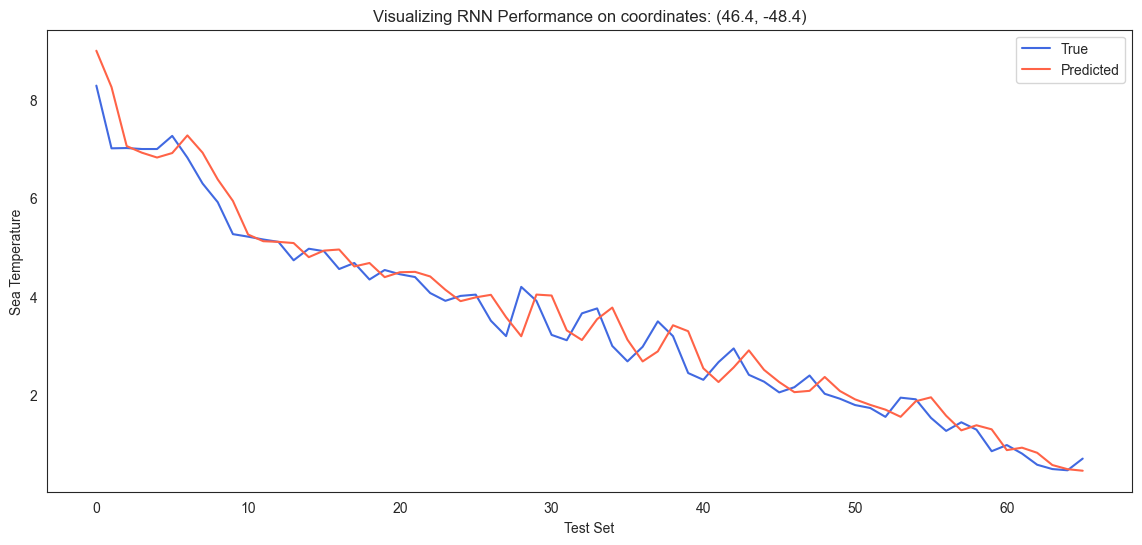

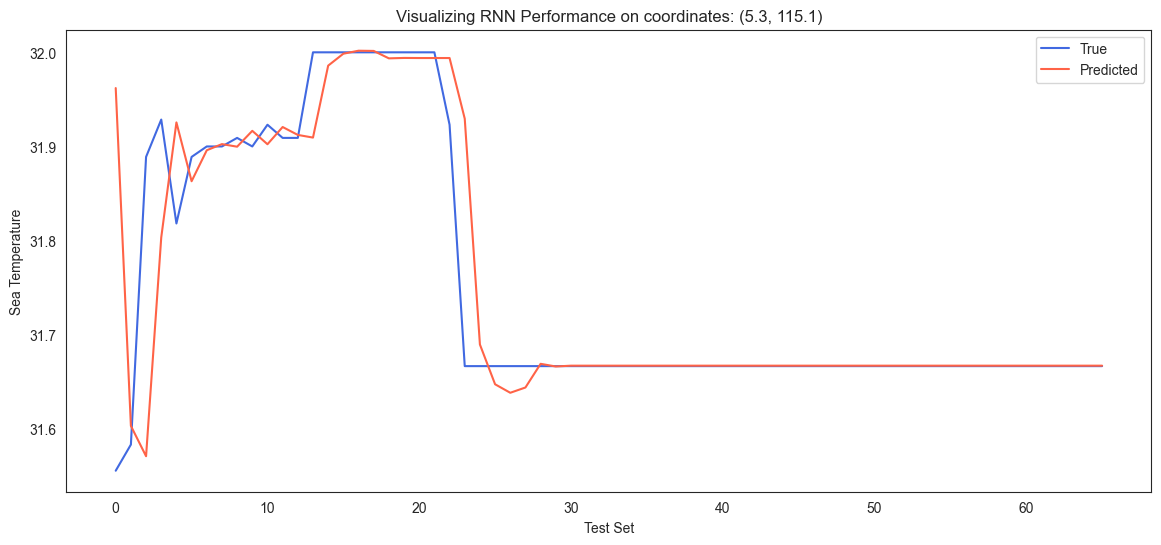

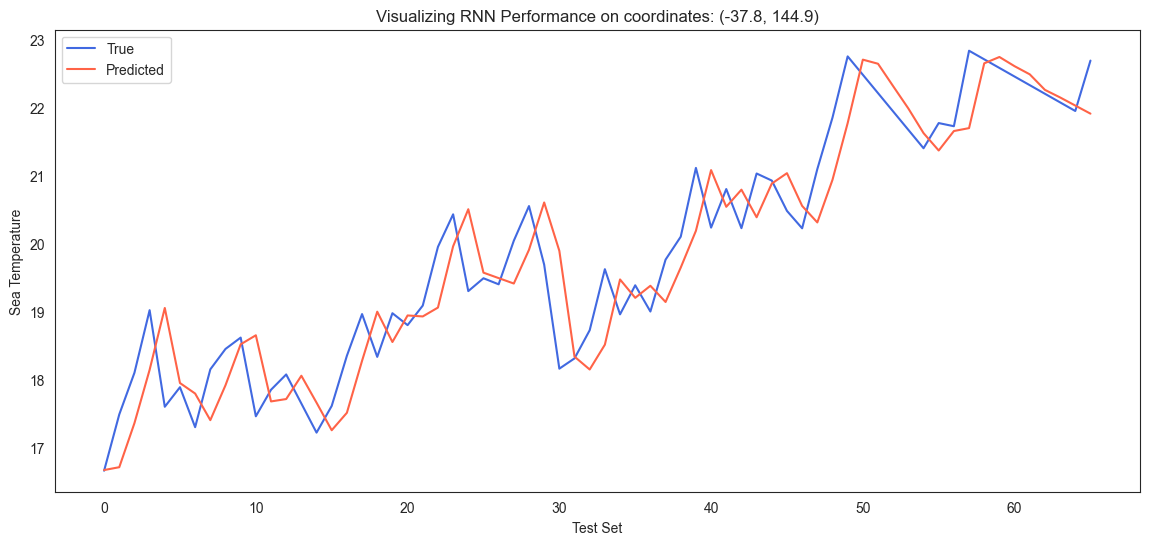

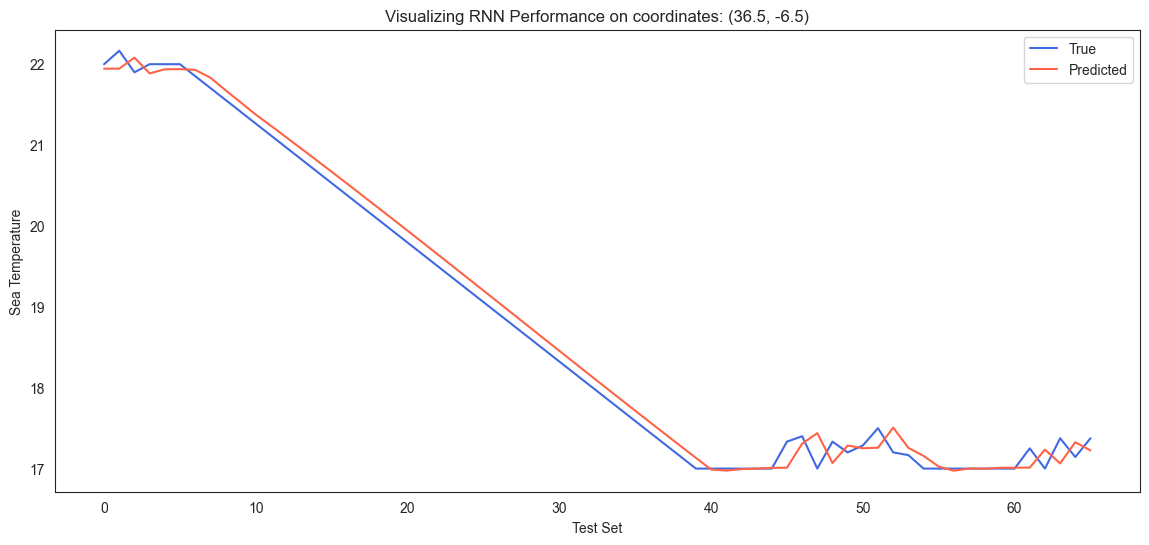

In [430]:
for i in df['lat, long'].unique():
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = rnn_preds[i]
    
    plt.figure(figsize=(14,6))

    plt.xlabel('Test Set')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing RNN Performance on coordinates: ({i})')

    sns.lineplot(y_true.flatten(), color='royalblue', label='True')
    sns.lineplot(y_pred.flatten(), color='tomato', label='Predicted')
    plt.show()

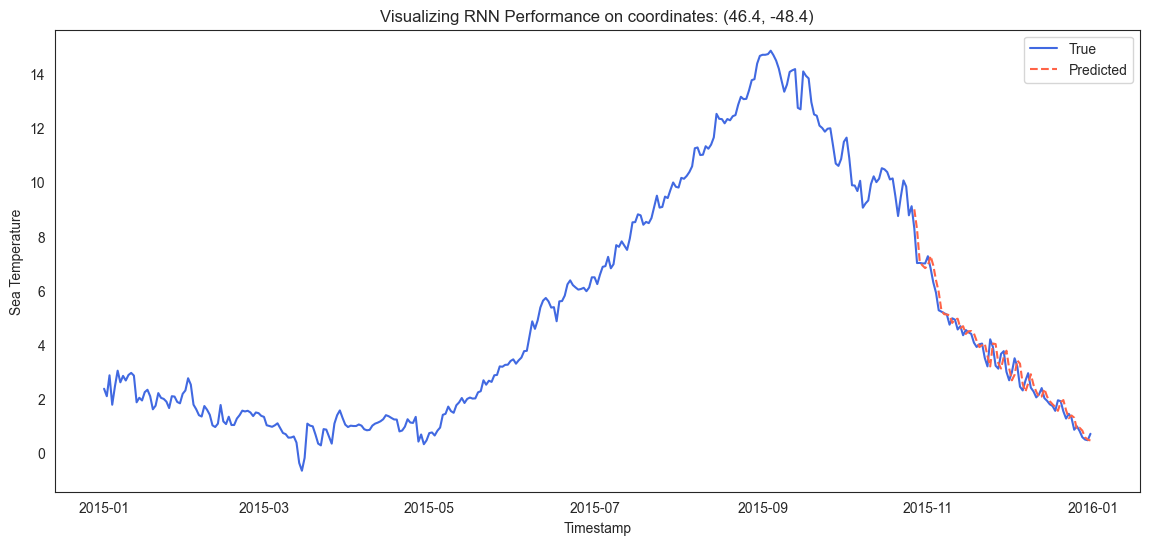

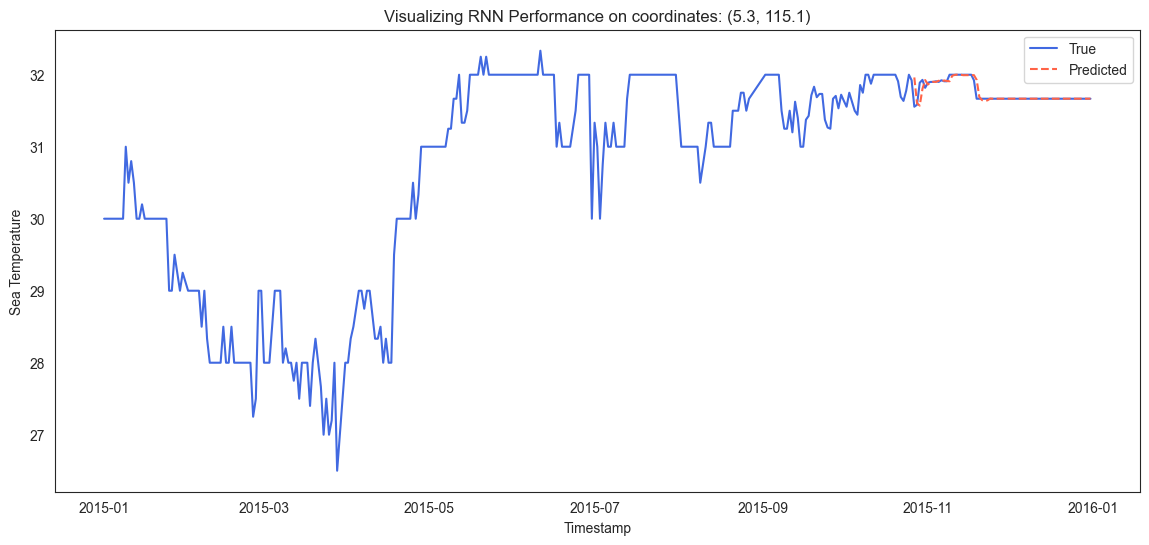

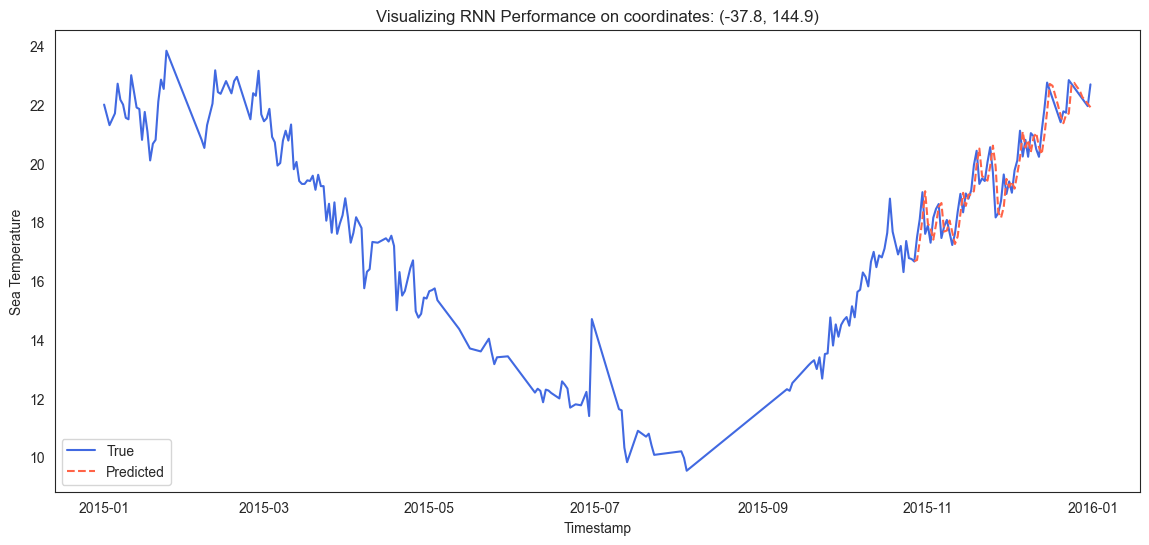

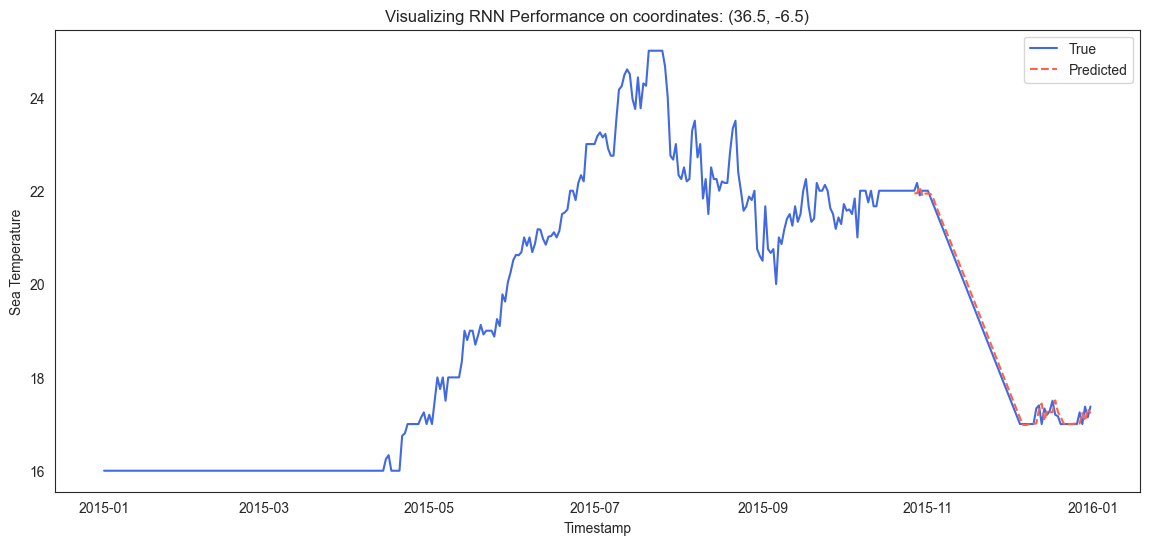

In [431]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")


# Define timestamp
timestamp = df['timestamp'].unique()

for i in df['lat, long'].unique():
    temps = rnn_preds[i].reshape(-1)
    adj = timestamp[365 - len(rnn_preds[i]):]
    temps = pd.DataFrame({'timestamp': adj, 'temps': temps})
    
    sub = df[df['lat, long'] == i]

    plt.figure(figsize=(14,6))
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color='royalblue')
    
    # Plot predicted sea temperature
    sns.lineplot(data=temps, x='timestamp', y='temps', label='Predicted', color='tomato', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing RNN Performance on coordinates: ({i})')
    plt.legend()
    
    # Show plot
    plt.show()


## LSTM

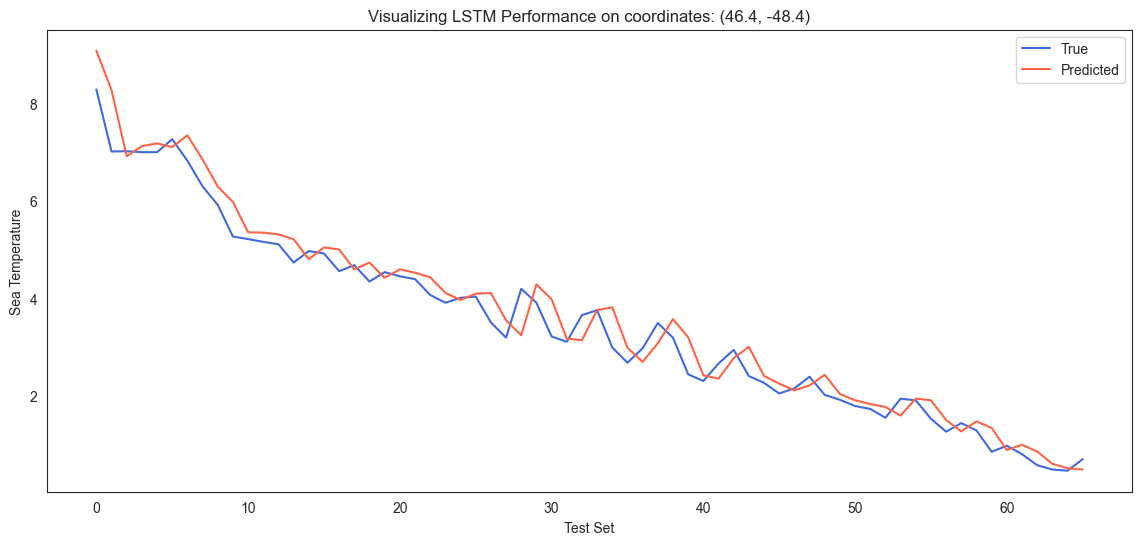

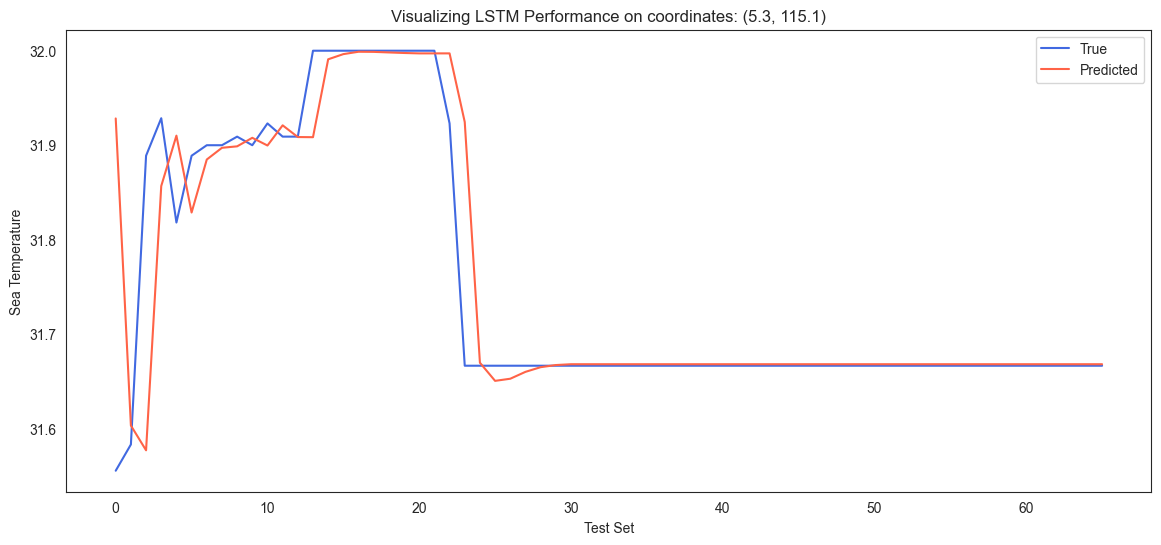

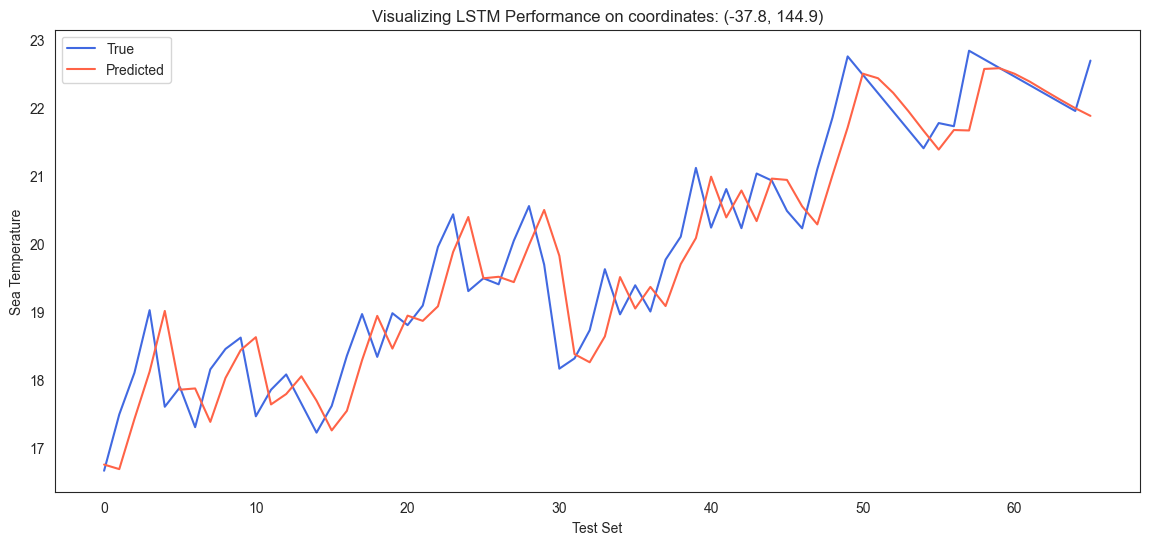

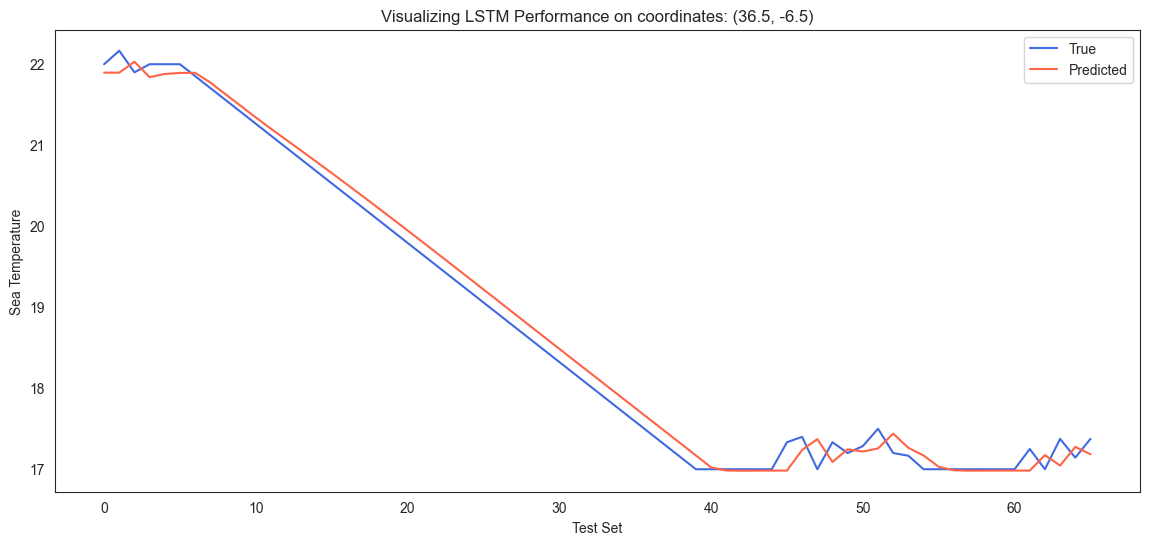

In [414]:
for i in df['lat, long'].unique():
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = lstm_preds[i]
    
    plt.figure(figsize=(14,6))

    plt.xlabel('Test Set')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing LSTM Performance on coordinates: ({i})')

    sns.lineplot(y_true.flatten(), color='royalblue', label='True')
    sns.lineplot(y_pred.flatten(), color='tomato', label='Predicted')
    plt.show()

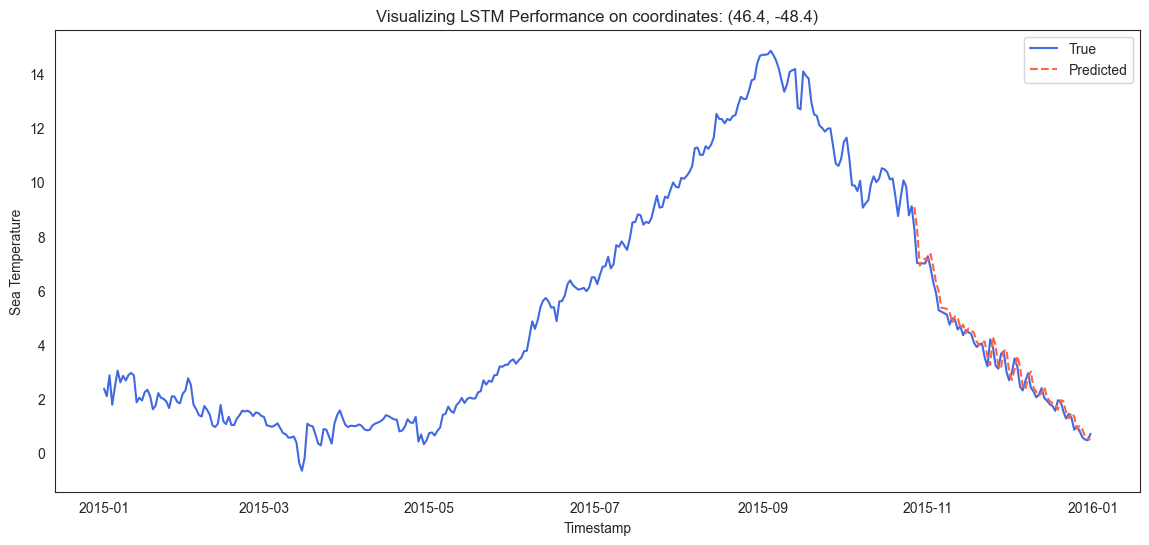

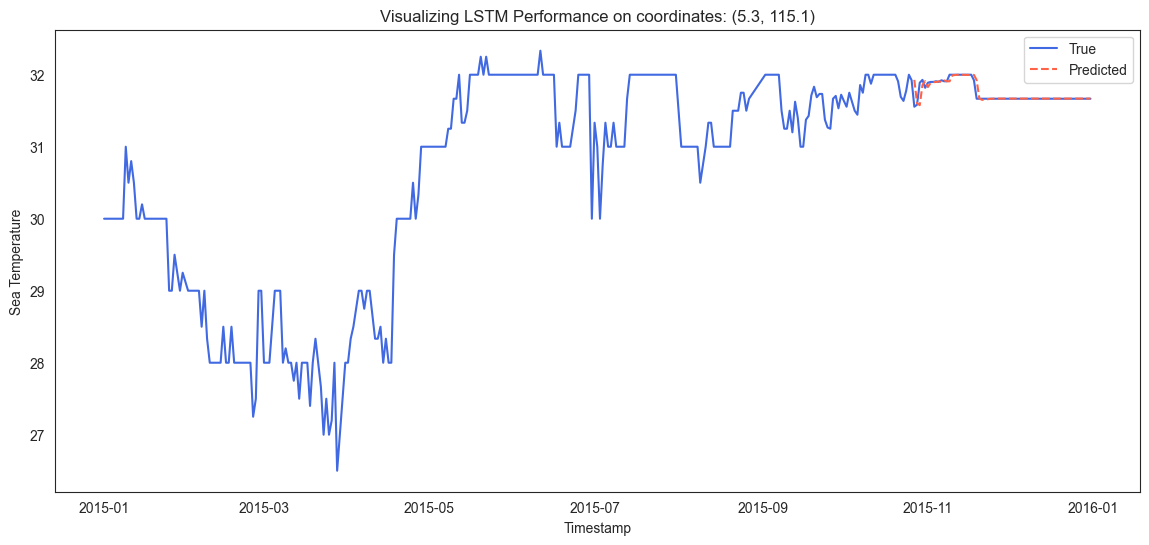

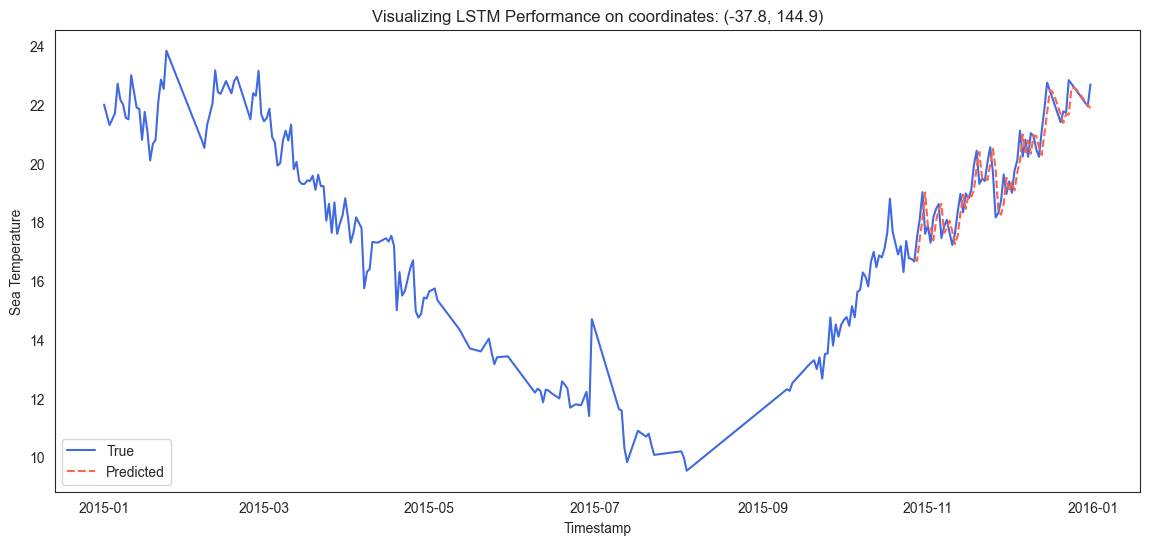

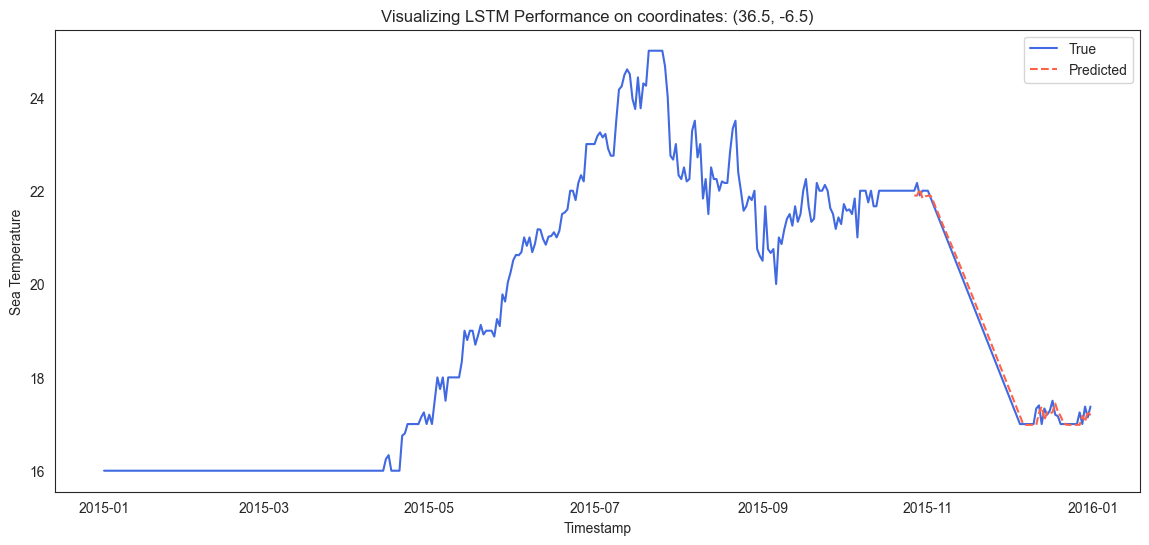

In [415]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")

# Define timestamp
timestamp = df['timestamp'].unique()

for i in df['lat, long'].unique():
    temps = lstm_preds[i].reshape(-1)
    adj = timestamp[365 - len(lstm_preds[i]):]
    temps = pd.DataFrame({'timestamp': adj, 'temps': temps})
    
    sub = df[df['lat, long'] == i]

    plt.figure(figsize=(14,6))
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color='royalblue')
    
    # Plot predicted sea temperature
    sns.lineplot(data=temps, x='timestamp', y='temps', label='Predicted', color='tomato', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing LSTM Performance on coordinates: ({i})')
    plt.legend()
    
    # Show plot
    plt.show()


# Comparing Models

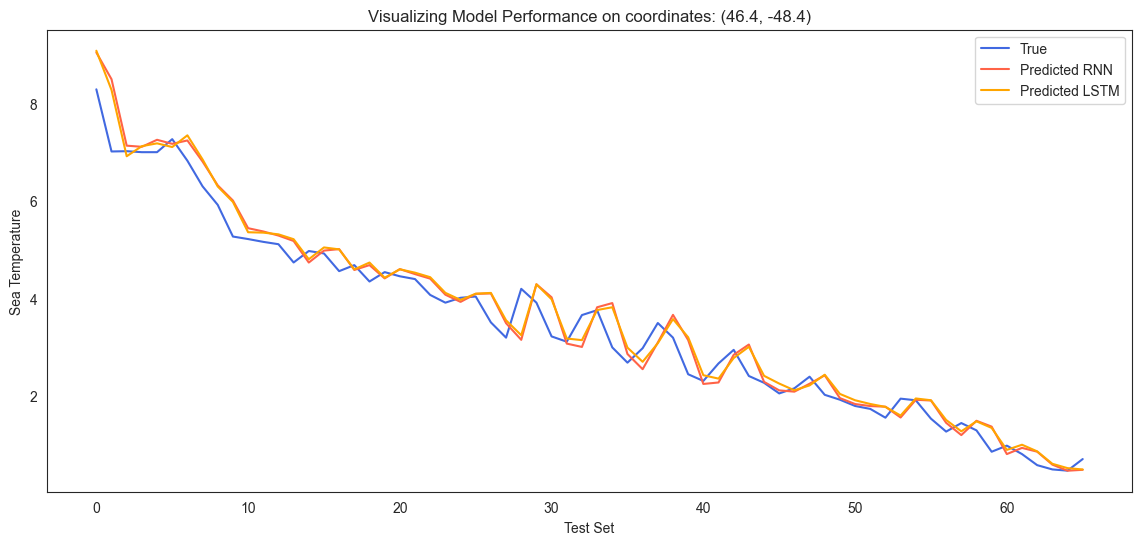

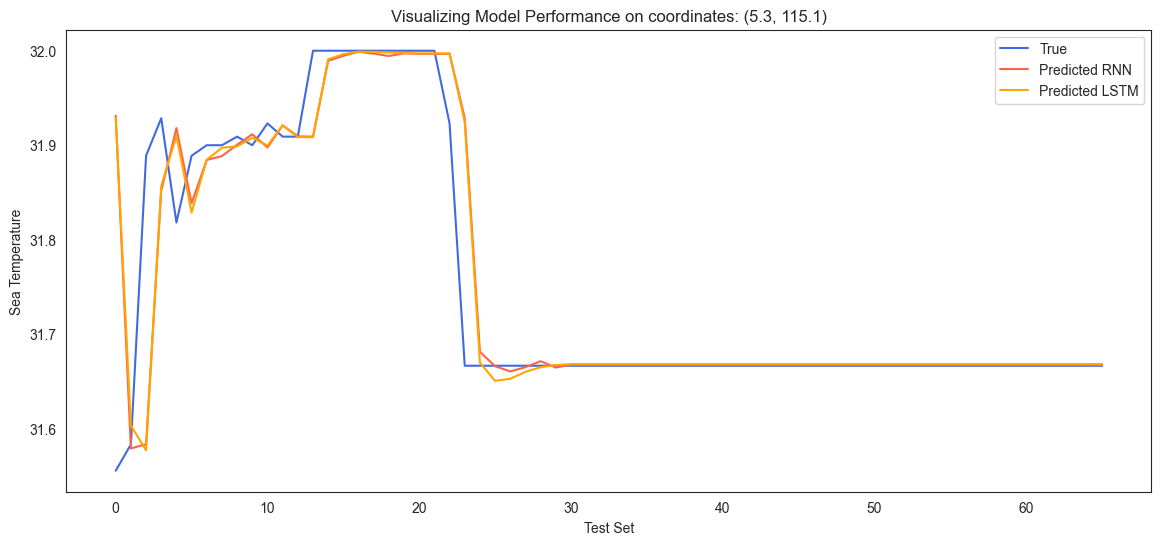

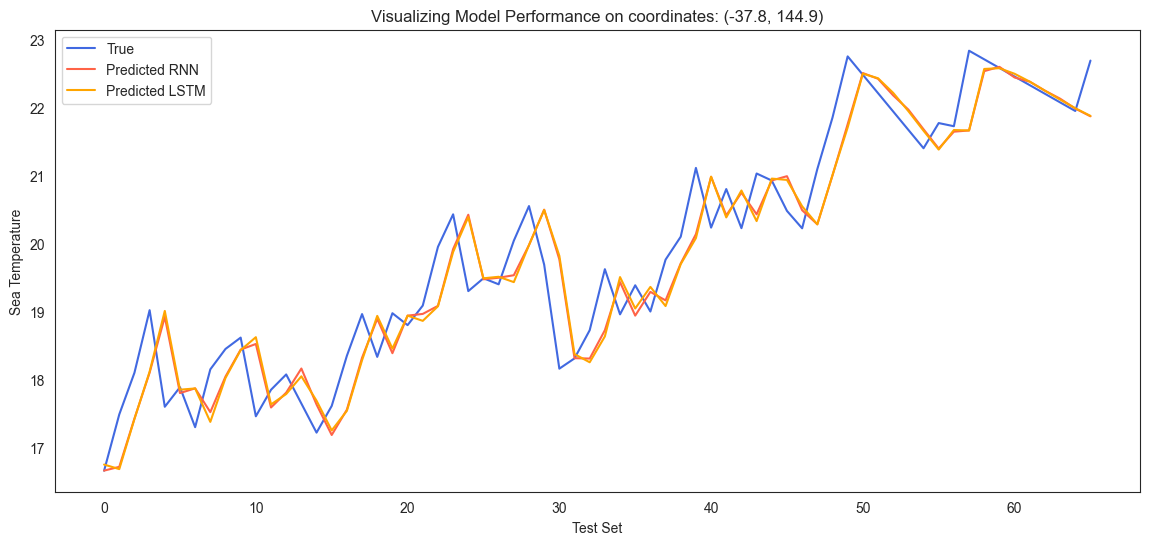

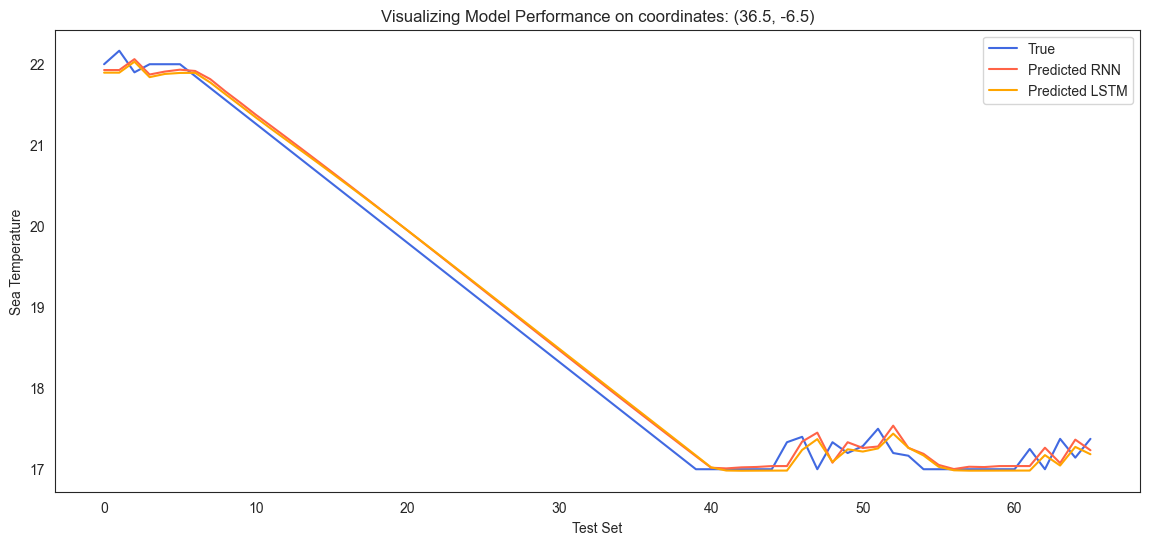

In [416]:
for i in df['lat, long'].unique():
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred_rnn = rnn_preds[i]
    y_pred_lstm = lstm_preds[i]
    
    plt.figure(figsize=(14,6))

    plt.xlabel('Test Set')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing Model Performance on coordinates: ({i})')

    sns.lineplot(y_true.flatten(), color='royalblue', label='True')
    sns.lineplot(y_pred_rnn.flatten(), color='tomato', label='Predicted RNN')
    sns.lineplot(y_pred_lstm.flatten(), color='orange', label='Predicted LSTM')
    plt.show()

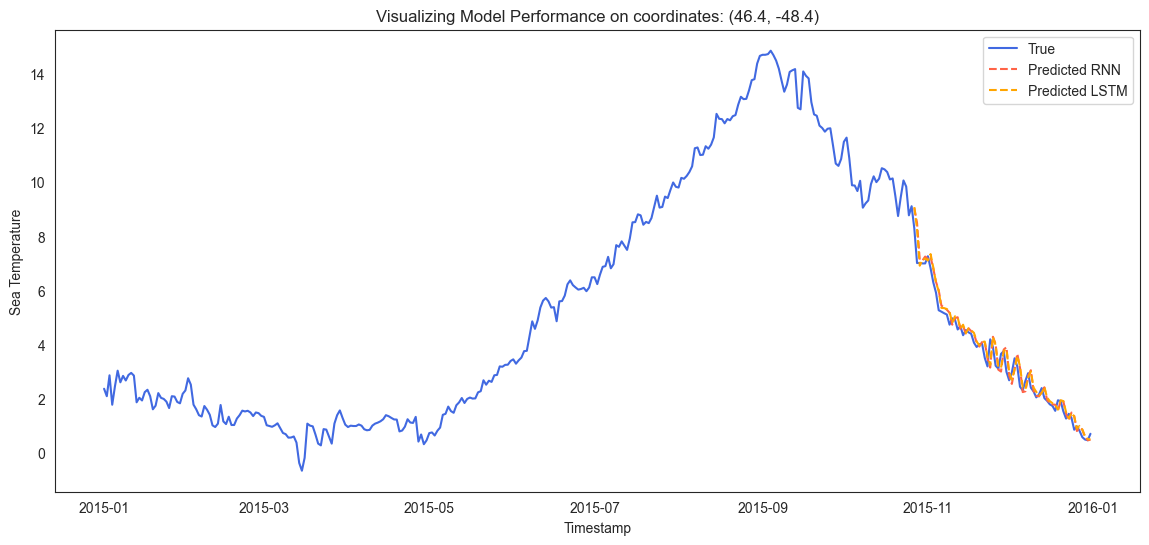

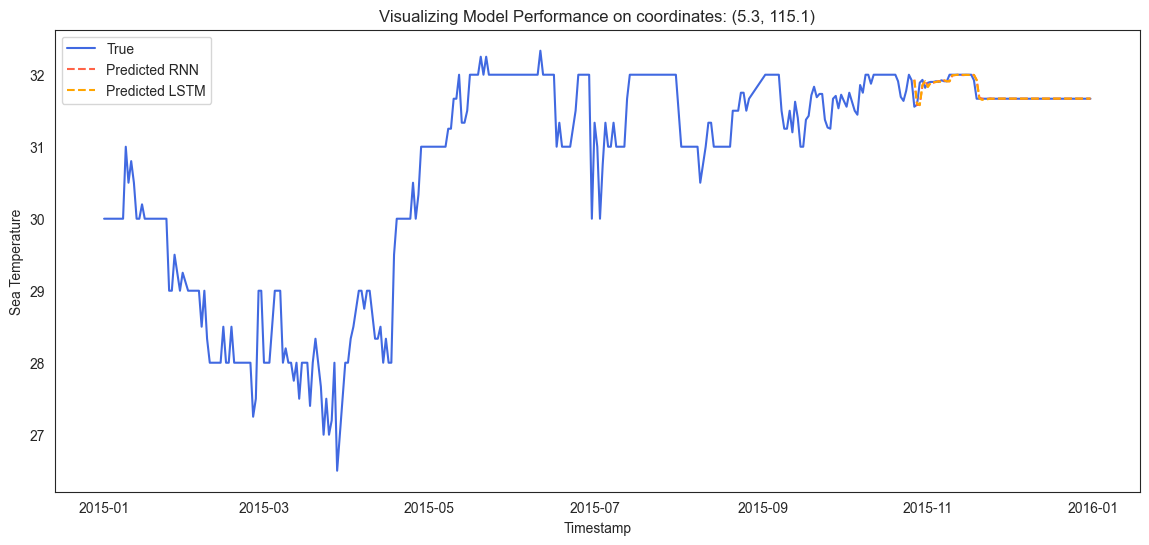

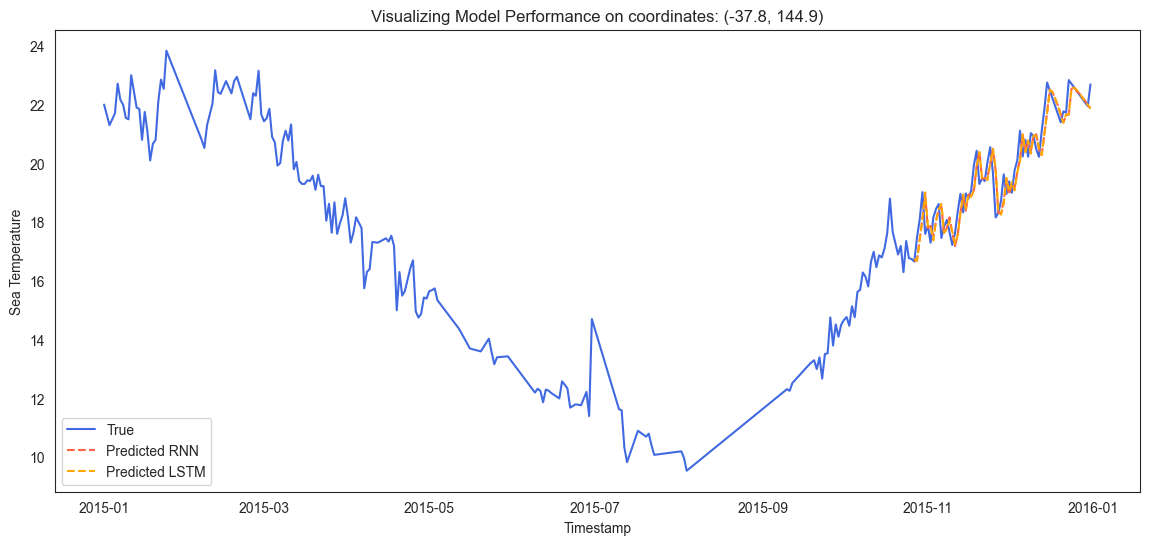

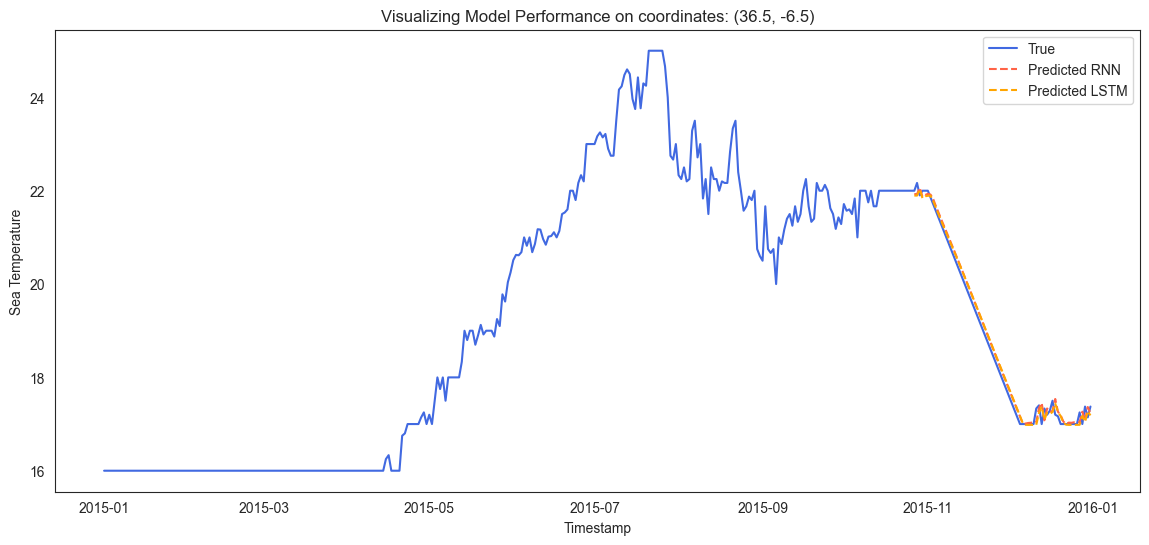

In [417]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")

# Define timestamp
timestamp = df['timestamp'].unique()

for i in df['lat, long'].unique():
    temps = rnn_preds[i].reshape(-1)
    adj = timestamp[365 - len(lstm_preds[i]):]
    
    temps_rnn = pd.DataFrame({'timestamp': adj, 'temps': temps})

    temps = lstm_preds[i].reshape(-1)
    temps_lstm = pd.DataFrame({'timestamp': adj, 'temps': temps})
    
    sub = df[df['lat, long'] == i]

    plt.figure(figsize=(14,6))
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color='royalblue')
    sns.lineplot(data=temps_rnn, x='timestamp', y='temps', label='Predicted RNN', color='tomato', linestyle='--')
    sns.lineplot(data=temps_lstm, x='timestamp', y='temps', label='Predicted LSTM', color='orange', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing Model Performance on coordinates: ({i})')
    plt.legend()
    
    # Show plot
    plt.show()
